## Analyzing Cape Town's day zero with Global Water Watch's API

[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/global-water-watch/gww-notebooks/blob/main/01_API_storage_anomalies_Cape_Town.ipynb)

In this notebook, we'll go over a number of examples how to request data from Global Water Watch (GWW)'s API. We will reproduce some of the research done in [this](https://www.nature.com/articles/s41598-022-17074-6) paper. It presents an analysis of dry conditions around Cape Town. You can download this notebook, reproduce the results and of course adapt it for your environment. Let's first install a few dependencies we'll need


In [1]:
!pip install geopandas
!pip install cartopy
!pip install tqdm

In [2]:
import geopandas as gpd
import json
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import requests
import cartopy
import cartopy.io.img_tiles as cimgt
import cartopy.crs as ccrs
import datetime

from dateutil.relativedelta import relativedelta
from scipy import stats
from shapely.geometry import shape, box, mapping

base_url = "https://api.globalwaterwatch.earth"
start = datetime.datetime(2021, 1, 1)
stop = datetime.datetime(2022, 1, 1)

### Helper functions
First we define a set of functions that we can later use to do requests on the API, massage data into a form that can be used more easily, like pandas or geopandas `DataFrame`, or plot the data. Load in the functions, and we'll use them later on. The documentation on the different API calls can be found [here](https://api.globalwaterwatch.earth/docs).

In [3]:
def to_geopandas(data):
    """
    Ingests list of reservoirs and converts into a geopandas GeoDataFrame for further analyses
    
    """
    gdf = gpd.GeoDataFrame.from_features(data, crs=4326)
    # reserovir ids are not in the feature itself, add explicitly
    reservoir_ids = [int(f["id"]) for f in data["features"]]
    gdf["id"] = reservoir_ids

#     geoms = [shape(f["geometry"]) for f in data]
#     props = [{**f["properties"], **{"id": f["id"]}} for f in data]
    return gdf
#     return gpd.GeoDataFrame(props, geometry=geoms, crs=4326)

def get_reservoirs(skip=1, limit=5, base_url=base_url):
    """
    Gets reservoirs from API. Return dict with IDs.
    
    """
    url = f"{base_url}/reservoir"
    params = {
        "skip": skip,
        "limit": limit,
    }
    return requests.get(url, params=params)


def get_reservoir(reservoir_id):
    """
    Get reservoir (geometry and props) by ID
    """
    url = f"{base_url}/reservoir/{reservoir_id}"
    return requests.get(url)
    

def get_reservoirs_by_geom(geom, base_url=base_url):
    """
    Gets reservoirs from API. Return dict with IDs.
    
    """
    url = f"{base_url}/reservoir/geometry"
    # do post request to end point with the serialized geometry as post data
    return requests.post(url, data=geom)


def get_reservoir_ts(reservoir_id, start=start, stop=stop):
    """
    Get time series data for reservoir with given ID
    """
    url = f"{base_url}/reservoir/{reservoir_id}/ts"
    params = {
        "start": start.strftime("%Y-%m-%dT%H:%M:%S"),
        "stop": stop.strftime("%Y-%m-%dT%H:%M:%S")
    }
    return requests.get(url, params=params)
    
    
def plot_features_map(feats, ax=None, figsize=(20, 13), tiles=None, zoom_level=1, tiles_kwargs={}, **kwargs):
    """
    add a set of features to a GeoAxes map
    """
    if ax is None:
        f = plt.figure(figsize=figsize)
        if tiles is not None:
            tiler = getattr(cimgt, tiles)(**tiles_kwargs)
            crs = tiler.crs
        else:
            crs = ccrs.PlateCarree()
        # make point collection
        ax = plt.subplot(projection=crs)
        if tiles is not None:
            ax.add_image(tiler, zoom_level, zorder=1)
            feats.to_crs(3857).plot(ax=ax, zorder=2, **kwargs)
        else:
            feats.plot(ax=ax, **kwargs)
    return ax

### Get some reservoirs and properties
The first functionality we show is a simple query on the order of IDs of reservoirs. These IDs are typical for global water watch. With options for `skip` and `limit` we can ask for reservoirs in a particular ID range. 

In [4]:
r = get_reservoirs(skip=50, limit=50)


Basically we just requested to skip the first 50 reservoirs in the database, and then retrieve the 50 after those. Let's have a look at the raw response.

In [5]:
r.json()

{'type': 'FeatureCollection',
 'features': [{'type': 'Feature',
   'geometry': {'coordinates': [[[[22.90807421935336, 55.26857770742545],
       [22.90831510991706, 55.26896119024121],
       [22.909559241512515, 55.26912620941748],
       [22.910089772249844, 55.268952280339],
       [22.910312715828727, 55.26858221745703],
       [22.91031271905811, 55.26812291884761],
       [22.909893676401417, 55.267659158527394],
       [22.908836816101232, 55.267578869522936],
       [22.908301658465913, 55.26775727118572],
       [22.90807870326886, 55.26812732606345],
       [22.90807421935336, 55.26857770742545]]]],
    'type': 'MultiPolygon'},
   'properties': {'name': None,
    'name_en': None,
    'grand_id': None,
    'source_name': 'osm',
    'source_id': 9185407},
   'id': '60',
   'bbox': None},
  {'type': 'Feature',
   'geometry': {'coordinates': [[[[105.39972703173329, 33.85813265598349],
       [105.39984294456002, 33.85886394708298],
       [105.40032009155118, 33.85912255813425],


We now have the response of our query in `r` and can now retrieve the data in json format. That's not very convenient as we can't easily analyze the data. So we wrote a convenience function to turn the json data into a geographically aware `geopandas.GeoDataFrame`. This makes it easier to use the data in a geospatial manner. Check out the function in the cell above, that you already loaded.

In [6]:
data = r.json()
gdf = gpd.GeoDataFrame.from_features(data, crs=4326)
gdf = to_geopandas(data)
gdf.head()


,geometry,name,name_en,grand_id,source_name,source_id,id
0,"MULTIPOLYGON (((22.90807 55.26858, 22.90832 55...",None,None,None,osm,9185407,60
1,"MULTIPOLYGON (((105.39973 33.85813, 105.39984 ...",None,None,None,osm_way,482505946,61
2,"MULTIPOLYGON (((-4.06713 40.76689, -4.06713 40...",Embalse de la Venta,None,None,osm_way,46263327,62
3,"MULTIPOLYGON (((124.14554 -17.81144, 124.14565...",None,None,None,osm_way,190517080,63
4,"MULTIPOLYGON (((-40.70401 -4.34273, -40.70384 ...",None,None,None,osm_way,542489657,65


It looks like we have something to plot now. We also wrote a function that plots the data within a geographical map. Since the reservoirs are distributed over the world, we only show the centroids below.

/var/folders/2b/wg0jj3c17h7_jxlfglq9nw100000gn/T/ipykernel_7542/1718508160.py:1: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  plot_features_map(gdf.centroid, tiles="OSM")


<GeoAxes: >

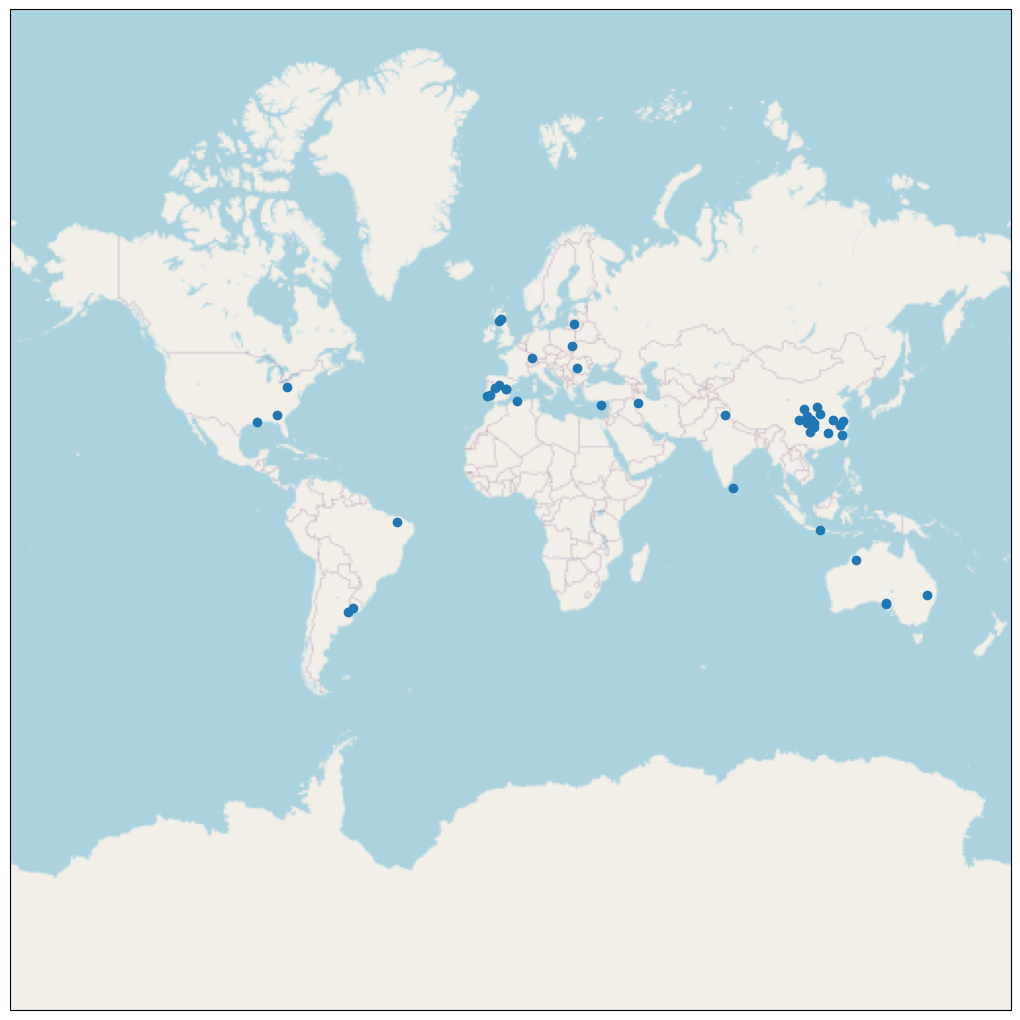

In [7]:
plot_features_map(gdf.centroid, tiles="OSM")


### Reservoirs in a certain bounding box
Interesting, but let's assume we would be interested to have data around Cape Town to investigate the 2016 drought event. Let's draw a bounding box around cape town and only retrieve reservoir IDs there! Below we first prepare a bounding box in so-called GeoJSON format. This format can be passed to the API.

In [8]:
# first we define a bounding box. We took this from a convenient tool on https://boundingbox.klokantech.com/
xmin, ymin, xmax, ymax = (17.948, -34.6538, 19.7361, -33.6857)
# we prepare a geometry from the coordinate with shapely.geometry.box
bbox = box(xmin, ymin, xmax, ymax)
# to pass this to our API, the geometry needs to be serialized to a json, so we first turn it into a dictionary 
# and then turn it into a string
json_dict = mapping(bbox)
json_str = json.dumps(json_dict)
json_str

'{"type": "Polygon", "coordinates": [[[19.7361, -34.6538], [19.7361, -33.6857], [17.948, -33.6857], [17.948, -34.6538], [19.7361, -34.6538]]]}'

Et voila! We have a string to pass into our API to retrieve reservoirs over a bounding box. Let's try this out.

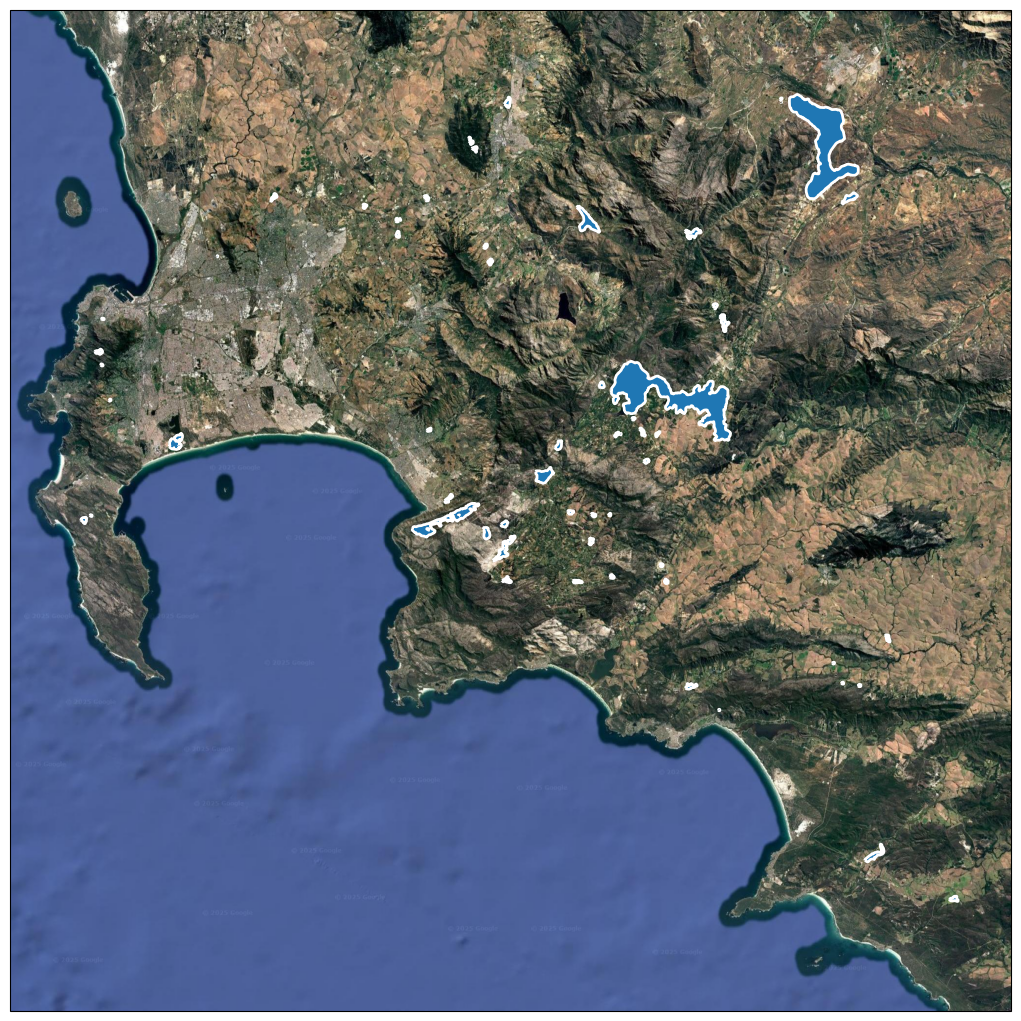

In [9]:
# get the reservoirs with a geometry
r = get_reservoirs_by_geom(json_str)
# convert into geopandas.GeoDataFrame
gdf = to_geopandas(r.json())

# plot with a more localized GoogleTiles background
plot_features_map(gdf, tiles="GoogleTiles", zoom_level=11, tiles_kwargs={"style": "satellite"}, edgecolor="w", linewidth=2)
plt.savefig("cape_reservoirs.jpg", dpi=200, bbox_inches="tight")

## Retrieve data for the given reservoirs
We now have an interesting list of reservoirs. We can almost start thinking about an analysis. Let us now retrieve the data for the largest reservoir in terms of its polygon area (of course this is time variable if you consider this strictly, the polygon merely gives an approximate outline). Below we retrieve the time series and we'll have a look at the data.

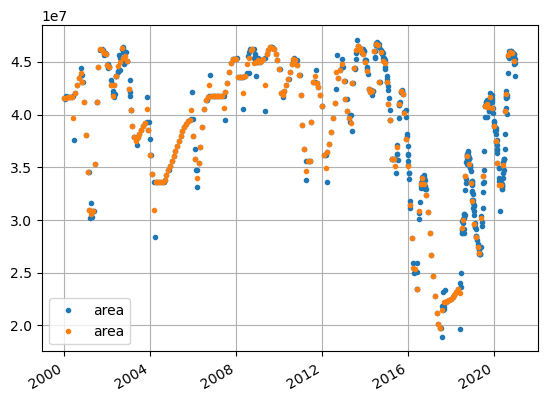

In [10]:
def to_timeseries(data, name=None):
    """
    Convert raw list of jsons to organized pandas.DataFrame
    """
    if name is None:
        name = "area"

    t_index = [p["t"] for p in data]
    v = [{name: p["value"]} for p in data]
    pd.DatetimeIndex(t_index)
    return pd.DataFrame(
        v,
        index=pd.DatetimeIndex(t_index)
    )

# first add an area estimate. We do this by projecting to a "meters" UTM projection, 
# ...computing the surface area, adding that as property
a = gdf.to_crs(32734).area
gdf["area"] = a

# now let's find the ID of the largest area reservoir (sort from small to large, last in the list, so index=-1)
# first we sort on area
gdf = gdf.sort_values("area")

# last in the list should be the largest now
reservoir_id = gdf.iloc[-1].id
s = datetime.datetime(2000, 1, 1)
e = datetime.datetime(2020, 12, 31)

# retrieve data for the largest reservoir
r = get_reservoir_ts(reservoir_id, start=s, stop=e)

# again, raw data are not easy to process, so we have a nice function to convert to pandas
df = to_timeseries(r.json())
ax = plt.subplot(111)
df.plot(ax=ax, linewidth=0., marker=".")

# let's also compute the monthly means so that we can more easily compare against other reservoirs
df_mean = df.resample("MS").mean()
df_mean.plot(ax=ax, marker=".", linewidth=0, label="monthly mean")
ax.grid()

Excellent, now we have some data in a form we can work with. We also have monthlies so that we can combine the data with the same time stamps with data from other reservoirs later.

### Data for all reservoirs in bounding box
It is clear that we have a logical reservoir pattern and that the period around "Day Zero" is very dry. But how does this relate to the surrounding reservoirs? Let's retrieve the data for those and establish monthly anomalies.
Below we start with just retrieving the data in the same way as what we did for the one largest reservoir above.

In [11]:
from tqdm.notebook import tqdm

data_per_reservoir = [
    to_timeseries(
        get_reservoir_ts(gdf["id"][n], start=s, stop=e).json(),
        name="area_{}".format(gdf["id"][n]))
    for n in tqdm(range(len(gdf)))
]


  0%|          | 0/61 [00:00<?, ?it/s]

### Measure the surface area against the climatology
For this we use the "Standardized Area Index", basically the same as the "Standardized Precipitation Index" but then applied on reservoirs. Below all the functionalities are programmed. Please have a look at the detailed docstrings to understand how they work.

In [12]:
def fit(ts, dist='norm', include_zero=False):
    """
    This function fits a distribution (e.g. default gamma, but can be altered to 
    genextreme, normal, or other supported by scipy.stats) from a number of samples. It can (should) be tested
    whether the process fits chosen distribution, e.g. with a goodness of fit or Q-Q plots.
    Input:
        samples            : the samples from the process, to be described by
                             the Gamma distribution
        dist:              : chosen distribution, compatible with scipy.stats
        include_zero       : Default: True, decide if probability of zero values occurring should be included 
                             explicitly
    Output:
        fit_params         : tuple with fit parameters of chosen distribution such as shape, location, scale
        prob_zero          : the probability of zero occurring (if relevant)

    """

    samples = ts.values.flatten()  # flatten the matrix to a one-dimensional array
    if include_zero:
        # compute probability of zero (only relevant for things like rainfall)
        prob_zero = float(sum(samples == 0)) / len(samples)
    else:
        prob_zero = 0.
    # find the amount of samples
    n = len(samples)
    # select the gamma distribution function to work with
    dist_func = getattr(stats, dist)
    # fit parameters of chosen distribution function, only through non-zero samples
    if include_zero:
        fit_params = dist_func.fit(samples[(samples != 0) & np.isfinite(samples)])
    else:
        fit_params = dist_func.fit(samples[np.isfinite(samples)])
    # following is returned from the function
    return fit_params, prob_zero

def quantile_trans(ts, fit_params, p_zero, dist='norm'):
    """
    This function detrermines the normal quantile transform of a number of samples, based on
    a known (e.g. Gamma) distribution of the process (can in principle
    be extended to support grids instead of point values)
    Input:
        samples            : the samples from the process, for which standardized index is
                             computed
        fit_params         : the distribution parameters (need to be of expected size for given distribution)
        loc                : the location (mean) parameter of the distribution
        beta               : the scale parameter of the distribution
        prob_zero          : the probability of zero-rainfall
        dist:              : chosen distribution, compatible with scipy.stats
    Output:
        standardized       : Standardized values of the given samples
    """
    # compute probability of non-exceeding of given sample(s), given the predefined Gamma distribution
    samples = ts.values
    # find zero samples (only relevant for processes that are zero-bounded such as fluxes, e.g. precipitation)
    if p_zero > 0:
        ii = samples == 0
    # find missings in samples
    jj = np.isnan(samples)
    # get the requested distribution
    dist_func = getattr(stats, dist)
    # compute the cumulative distribution function quantile values using the fitted parameters
    cdf_samples = dist_func.cdf(samples, *fit_params)
    # correct for no rainfall probability
    cdf_samples = p_zero + (1 - p_zero) * cdf_samples
    if p_zero > 0:
        cdf_samples[ii] = p_zero
    cdf_samples[jj] = np.nan
    # compute inverse normal distribution with mu=0 and sigma=1, this yields the standardized values. 
    # Basically this means looking up how many standard deviations the given quantile represents in 
    # a normal distribution with mu=0. and sigma=1.
    standardized = stats.norm.ppf(cdf_samples)
    return standardized

def fit_and_transform(samples, dist='norm', include_zero=True):
    # The function below fits the samples to the requested distribution 'norm' or other from scipy.stats
    fit_params, p_zero = fit(samples, dist=dist, include_zero=include_zero)
    # Then the fitted parameters are used to estimate the standardized samples for each invidual month
    standardized_samples = quantile_trans(samples, fit_params, p_zero, dist=dist)
    # finally, the standardized samples are put into a pandas timeseries again, so that we can easily make time series plots
    # and do further analyses
    return pd.Series(standardized_samples, index=samples.index)

def compute_standard_index(ts, index='time.month', dist='norm', include_zero=True):
    """
    Compute standardised index. This is done on monthly time series by:
    - grouping the monthly data into monthly bins
    - for each month fit a distribution function (normal or other from scipy.stats)
    - estimate the probability of exceedance of each point in the time series using the 12 distributions
    - estimate the normal transform of each probability found using mapping to a standard normal distribution
    Input:
        ts: pandas Series object containing monthly data (e.g. monthly precipitation, precip-ref. evaporation)
        index='time.month': index to use for grouping
        dist='norm': distribution to use.
    """
    # first, we group all values per month. So we get a group of January rainfalls, February rainfalls, etc.
    ts_group = ts.groupby(index)
    # for each group, the SPI values are computed and coerced into a new time series. 
    standardized_index = ts_group.apply(fit_and_transform, dist=dist, include_zero=include_zero)
    return standardized_index

### Monthly values
Let's perform resampling to monthly values so that we can apply the monthly standardized index functionality.

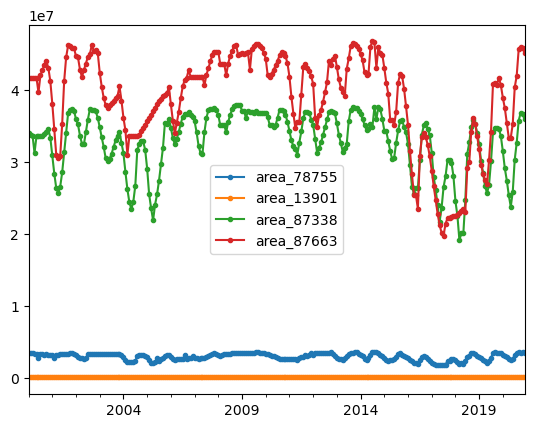

In [13]:
# resample data for each reservoir to monthly means and concatenate to a new pandas.DataFrame
data_monthly = pd.concat([data.resample("MS").mean() for data in data_per_reservoir], axis=1)
# plot the last 4 (the largest)
data_monthly.iloc[:, -4:].plot(marker=".")
plt.savefig("cape_time_series.jpg", dpi=200)

### Anomalies
Now that we have monthly values, we can measure monthly deviations from climatology expressed in standard deviations using the helper functions just loaded. We assume here the the normal distribution fits the sampled monthly values reasonably well, but you can alter that to other distributions if deemed a better fit. Googness of fit testing is here not further shown.

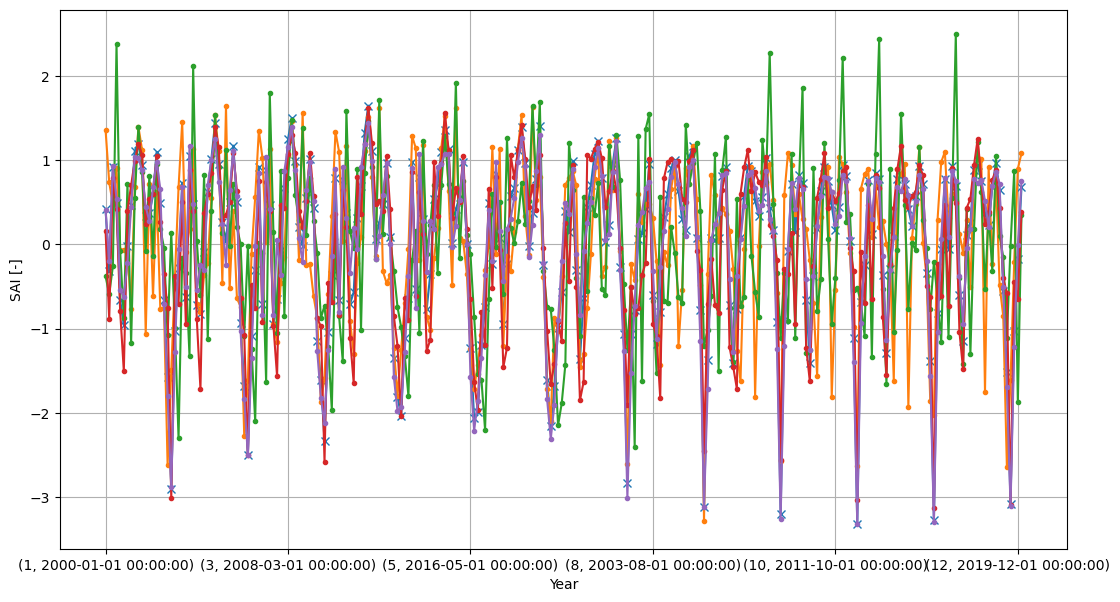

In [14]:
f = plt.figure(figsize=(13, 7))
ax = f.add_subplot(111)
index = data_monthly.index.month
sai = data_monthly.interpolate().apply(compute_standard_index, index=index, dist="norm")

# also make an estimate of the total surface area per month and apply the
area_total = data_monthly.interpolate().sum(axis=1)
sai_total = compute_standard_index(area_total, index=area_total.index.month, dist="norm")
sai_total.plot(marker="x")
sai.iloc[:, -4:].plot(ax=ax, marker=".", legend=False)
plt.xlabel("Year")
plt.ylabel("SAI [-]")
plt.grid()
plt.savefig("cape_sai.jpg", dpi=200)

### Some scripting for a geospatial video
To animate how the situation evolves in time, we can combine our data with a Mapbox background and some `cartopy` and `matplotlib` methods.

In [24]:
from matplotlib import animation
from IPython.display import HTML
import matplotlib

from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

area = gdf["area"].values
utm_geom = gdf.geometry.to_crs(32734)

# get the centroid in lat lon coordinates
x = utm_geom.centroid.to_crs(4326).x.values
y = utm_geom.centroid.to_crs(4326).y.values

start_date = "2015-01-01"
end_date = "2020-12-01"

dates = pd.date_range("2015-01-01", "2020-12-01", freq="MS")

datestr1 = dates[0]
datestr2 = datestr1 + relativedelta(days=1)

osm = cimgt.OSM()
f = plt.figure(figsize=(16, 9), frameon=False)
ax = plt.subplot(111, projection=osm.crs)

# Setting extent with on-the-fly reprojection will work in later versions of python)
# uncomment below in case you are running this in your own python env. to get a
# more close matching bounding box for the available data.
# ============================================================================= 
# ax.set_extent([18, 20, -34.7, -33.5], crs=ccrs.PlateCarree())
# ============================================================================= 

ax.add_image(osm, 9, interpolation='bilinear')
bounds = np.linspace(-3., 3., 9)
norm = matplotlib.colors.BoundaryNorm(boundaries=bounds, ncolors=256)
p = ax.scatter(
    x,
    y,
    s=area/2e4,
    c=sai.loc[datestr1:datestr2].values.flatten(),
    transform=ccrs.PlateCarree(),
    alpha=0.8,
    cmap="RdYlBu",
    norm=norm,
    edgecolor="#555555",
    linewidth=2,
)
# Gridlines with on-the-fly reprojection will work in later versions of python)
# uncomment below in case you are running this in your own python env.
# ============================================================================= 
# gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
#                   linewidth=1, color='gray', alpha=0., linestyle='--')
# gl.top_labels = False
# gl.left_labels = False
# gl.xformatter = LONGITUDE_FORMATTER
# gl.yformatter = LATITUDE_FORMATTER
# ============================================================================= 

cb = plt.colorbar(p, extend="both")
cb.set_label("Standardised Area Index [-]")
title = plt.title(f"Standardized Area Index {datestr1}")

# # add time series inset
ax_inset = ax.inset_axes([0.6, 0.05, 0.38, 0.15])

# plot a time slider
m1 = ax_inset.plot(dates[0], sai_total[sai_total.index==dates[0]], label="Southern Africa", marker=".", color='red', markersize=20)
sai_total[start_date:end_date].plot(ax=ax_inset, label="Southern Africa", color="red")
i = sai_total[start_date:end_date].index
pd.DataFrame({"zero_ax": np.zeros(len(i))}, index=i).plot(color="#888888", linewidth=0.6, ax=ax_inset, legend=False)

# lay out of the inset plot with SAI for all reservoirs together
ax_inset.set_ylabel("Standardize Area Index [-]")
ax_inset.set_xlabel("")
ax_inset.set_ylabel("")
ax_inset.patch.set_alpha(0.6)
ax_inset.set_ylim([-4, 4])
ax_inset.spines['top'].set_visible(False)
ax_inset.spines['right'].set_visible(False)
ax_inset.spines['bottom'].set_visible(False)
ax_inset.spines['left'].set_visible(False)
ax_inset.tick_params(axis='both', colors='black')


ax_inset.tick_params(axis='x', labelsize=8)
tick_locs = np.arange(2014, 2022)
ticks = ax_inset.xaxis.set_major_locator(matplotlib.ticker.FixedLocator(tick_locs))
ticklabels = ax_inset.set_xticklabels([str(tick) for tick in tick_locs], rotation = 0)

def update_plot(i):
    datestr1 = dates[i]
    datestr2 = datestr1 + relativedelta(days=1)
    p.set_array(sai[datestr1:datestr2].values.flatten())
    m1[0].set_xdata(dates[i])
    m1[0].set_ydata(sai_total[dates[i]])
    ax.set_title(f"Standardized Area Index {datestr1}")

matplotlib.rcParams['animation.embed_limit'] = 1e9
ani = animation.FuncAnimation(f, update_plot, frames=tqdm(range(len(dates))), interval=500)
plt.close()

# uncomment the line below to store the movie in a file instead of a on-the-fly HTML video
# ============================================================================= 
# ani.save("sai_southern_africa.mp4", fps=2, dpi=200)
# ============================================================================= 
# comment the line below to not show the video here in line
# ============================================================================= 
HTML(ani.to_jshtml())
# ============================================================================= 


TypeError: Level type mismatch: 2015-01-01 00:00:00

HTTP Error 429: Too many requests
HTTP Error 429: Too many requests
HTTP Error 429: Too many requests
HTTP Error 429: Too many requests
HTTP Error 429: Too many requests
HTTP Error 429: Too many requests
HTTP Error 429: Too many requests
HTTP Error 429: Too many requests
HTTP Error 429: Too many requestsHTTP Error 429: Too many requests

HTTP Error 429: Too many requests
HTTP Error 429: Too many requests
HTTP Error 429: Too many requests
HTTP Error 429: Too many requests
HTTP Error 429: Too many requests
HTTP Error 429: Too many requests
HTTP Error 429: Too many requests
HTTP Error 429: Too many requests
HTTP Error 429: Too many requests
HTTP Error 429: Too many requests
HTTP Error 429: Too many requests
HTTP Error 429: Too many requests
HTTP Error 429: Too many requests
HTTP Error 429: Too many requests
HTTP Error 429: Too many requests
HTTP Error 429: Too many requests
HTTP Error 429: Too many requests
HTTP Error 429: Too many requests
HTTP Error 429: Too many requests
HTTP Error 429

KeyboardInterrupt: 

Error in callback <function flush_figures at 0x16c6b2de0> (for post_execute), with arguments args (),kwargs {}:


KeyboardInterrupt: 

HTTP Error 429: Too many requests
HTTP Error 429: Too many requests
HTTP Error 429: Too many requests
HTTP Error 429: Too many requests
HTTP Error 429: Too many requests
HTTP Error 429: Too many requests
HTTP Error 429: Too many requestsHTTP Error 429: Too many requests
HTTP Error 429: Too many requests
HTTP Error 429: Too many requests

HTTP Error 429: Too many requests
HTTP Error 429: Too many requests
HTTP Error 429: Too many requests
HTTP Error 429: Too many requests
HTTP Error 429: Too many requests
HTTP Error 429: Too many requests
HTTP Error 429: Too many requests
HTTP Error 429: Too many requests
HTTP Error 429: Too many requests
HTTP Error 429: Too many requests
HTTP Error 429: Too many requests
HTTP Error 429: Too many requests
HTTP Error 429: Too many requests
HTTP Error 429: Too many requests
HTTP Error 429: Too many requests
HTTP Error 429: Too many requests
HTTP Error 429: Too many requests
HTTP Error 429: Too many requests
HTTP Error 429: Too many requests
HTTP Error 429

In [25]:
# Step 1: Filter for January 2018 (date is level 1 of MultiIndex)
target_date = pd.Timestamp("2018-01-01")
sai_2018 = sai.loc[sai.index.get_level_values(1) == target_date]

# Step 2: Collapse to a Series (index = reservoir ID, value = SAI)
sai_2018 = sai_2018.droplevel(1).squeeze()

# Step 3: Prepare spatial centroids
gdf_centroids = gdf.copy()
gdf_centroids["geometry"] = gdf.geometry.to_crs(32734).centroid.to_crs(4326)

# Step 4: Match on reservoir ID
# Align gdf index to 'area_XXXX' style
gdf_centroids["res_id"] = gdf_centroids.index.astype(str)
sai_2018.index = sai_2018.index.astype(str)

# Step 5: Join and clean
joined = gdf_centroids.set_index("res_id").join(sai_2018.rename("sai_2018"))
joined = joined.dropna(subset=["sai_2018"])  # keep only matching reservoirs

# Optional: mark critical risk
joined["critical_risk"] = joined["sai_2018"] < -2

# Step 6: Export to GPKG
joined[["geometry", "area", "sai_2018", "critical_risk"]].to_file("reservoir_jan2018.gpkg", layer="jan_2018", driver="GPKG")


In [26]:
# Ensure GeoDataFrame is in WGS84 for QGIS compatibility
gdf_export = gdf.to_crs(4326)

# Export to GeoPackage
gdf_export.to_file("reservoir_outlines.gpkg", layer="reservoirs", driver="GPKG")

In [28]:
import numpy as np

# Start from gdf with reservoir outlines
gdf_mock = gdf.to_crs(4326).copy()
gdf_mock["res_id"] = gdf_mock.index.astype(str)

# Generate approximate SAI values based on position (very roughly)
def mock_sai(geom):
    lon, lat = geom.centroid.x, geom.centroid.y
    if lon > 19 and lat > -34.2:
        return np.random.uniform(-2.8, -2.0)  # Worcester/Villiersdorp: critical
    elif lon > 18.6 and lat > -34.2:
        return np.random.uniform(-2.0, -1.0)  # Cape Town region: high
    elif lon < 18.6:
        return np.random.uniform(-1.0, 0.0)   # coastal/mixed zones
    else:
        return np.random.uniform(0.0, 1.0)    # low or improving

gdf_mock["sai_2018"] = gdf_mock.geometry.apply(mock_sai)

# Classify severity
def classify(sai):
    if sai < -2:
        return "critical"
    elif sai < -1:
        return "high"
    elif sai < 0:
        return "moderate"
    else:
        return "normal"

gdf_mock["severity"] = gdf_mock["sai_2018"].apply(classify)

# Export to GPKG
gdf_mock[["geometry", "sai_2018", "severity"]].to_file("mocked_reservoirs_jan2018.gpkg", layer="mocked_jan_2018", driver="GPKG")
